In [26]:
import numpy as np
import pandas as pd
import math
import os
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedKFold, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
from itertools import compress
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier as RFC, AdaBoostClassifier as ABC, GradientBoostingClassifier as GBC
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.metrics import accuracy_score

from sklearn.metrics import roc_curve, auc
from itertools import compress
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score,recall_score,confusion_matrix

import tensorflow as tf
from tensorflow import keras
from keras.models import load_model
import pickle

from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense,SimpleRNN,LSTM,Activation,SpatialDropout1D
import gensim

In [2]:
def SaveData(_data,_file_name):
    outer = open(f'{_file_name}','wb')
    pickle.dmp(_data,outer)
    outer.close()
    
def LoadData(_file_name):
    loader = open(f'{_file_name}','rb')
    _data = pickle.load(loader)
    loader.close()
    return _data

In [3]:
comments_sent = LoadData('comments_sent_labeled(NADJVCON).pickle')
comments_taged= LoadData('comments_taged_labeled(NADJVCON).pickle')

In [4]:
pure_sents = []
pure_labels = []

data=[]
for x in comments_sent:
    pure_labels.append(x['label'])
    pure_sents.append(x['content'])

X = np.array(pure_sents)
y = np.array(pure_labels)


for i in range(X.shape[0]):
    chiz = (X[i], y[i])
    data.append(chiz)
    


In [5]:
model1 = gensim.models.KeyedVectors.load_word2vec_format('FarsiWikiWord2Vec.model') 

In [6]:
word_vectors = model1.wv

C:\Users\Kuroush\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


In [7]:
MAX_NB_WORDS = len(word_vectors.vocab)
MAX_SEQUENCE_LENGTH = 200

In [8]:
embedding_matrix= word_vectors.vectors
embedding_matrix.shape

(270594, 100)

In [9]:
def get_tag_vocabulary(tagged_words):
    
    tag2id = {}
    for item in tagged_words:
        tag = item[1]
        tag2id.setdefault(tag, len(tag2id))
    return tag2id

#word2id = {k: v.index for k, v in word_vectors.vocab.item()}
tag2id = get_tag_vocabulary(data)

In [89]:
HIDDEN_SIZE=50
BATCH_SIZE=128
EMB_DIM=100
def define_model(embedding_matrix,class_count):
    vocab_length = len(embedding_matrix)

    model = Sequential()
    model.add(Embedding(input_dim=vocab_length,
                        output_dim=EMB_DIM,
                        weights=[embedding_matrix],
                        input_length=100,
                        trainable=True))
    #model.add(Flatten())
    model.add(LSTM(HIDDEN_SIZE,dropout=0.5))
    model.add(Dense(class_count, activation='softmax'))
    
    model.compile(optimizer='adam',
                 loss="categorical_crossentropy",
                 metrics=["accuracy"])
    return model

pos_model = define_model(embedding_matrix, len(tag2id))
pos_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 100, 100)          27059400  
_________________________________________________________________
lstm_4 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dense_24 (Dense)             (None, 3)                 153       
Total params: 27,089,753
Trainable params: 27,089,753
Non-trainable params: 0
_________________________________________________________________


In [90]:
 len(tag2id)

3

In [10]:
from keras import preprocessing
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import  to_categorical

maxlen = 100 #number of words we look at each sample 
training_samples = 400
validation_samples = 1480
max_words = 500 # number of features 


tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X)

sequences = tokenizer.texts_to_sequences(X)
word_index = tokenizer.word_index

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(y)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

y_cat=to_categorical(labels,3)

x_train = data[:training_samples]
y_train = y_cat[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = y_cat[training_samples: training_samples + validation_samples]


In [92]:
history = pos_model.fit(x_train, y_train,batch_size= BATCH_SIZE,epochs=100,verbose=1,validation_data=(x_val, y_val))

Train on 400 samples, validate on 1480 samples
Epoch 1/100
400/400 [==============================] - 6s 15ms/step - loss: 1.2234 - acc: 0.2875 - val_loss: 1.0585 - val_acc: 0.4399
Epoch 2/100
400/400 [==============================] - 3s 6ms/step - loss: 1.1409 - acc: 0.3500 - val_loss: 1.0025 - val_acc: 0.5135
Epoch 3/100
400/400 [==============================] - 3s 6ms/step - loss: 1.0625 - acc: 0.4325 - val_loss: 0.9851 - val_acc: 0.5182
Epoch 4/100
400/400 [==============================] - 3s 6ms/step - loss: 1.0476 - acc: 0.4325 - val_loss: 0.9775 - val_acc: 0.5264
Epoch 5/100
400/400 [==============================] - 3s 6ms/step - loss: 1.0410 - acc: 0.4825 - val_loss: 0.9726 - val_acc: 0.5291
Epoch 6/100
400/400 [==============================] - 3s 6ms/step - loss: 1.0117 - acc: 0.5000 - val_loss: 0.9659 - val_acc: 0.5345
Epoch 7/100
400/400 [==============================] - 3s 6ms/step - loss: 1.0066 - acc: 0.5075 - val_loss: 0.9603 - val_acc: 0.5372
Epoch 8/100
400/400 [

Epoch 62/100
400/400 [==============================] - 2s 6ms/step - loss: 0.6433 - acc: 0.7375 - val_loss: 0.7826 - val_acc: 0.6568
Epoch 63/100
400/400 [==============================] - 3s 6ms/step - loss: 0.6636 - acc: 0.7200 - val_loss: 0.7823 - val_acc: 0.6595
Epoch 64/100
400/400 [==============================] - 3s 6ms/step - loss: 0.6395 - acc: 0.7425 - val_loss: 0.7794 - val_acc: 0.6676
Epoch 65/100
400/400 [==============================] - 2s 6ms/step - loss: 0.6165 - acc: 0.7300 - val_loss: 0.7786 - val_acc: 0.6716
Epoch 66/100
400/400 [==============================] - 2s 6ms/step - loss: 0.6261 - acc: 0.7575 - val_loss: 0.7791 - val_acc: 0.6696
Epoch 67/100
400/400 [==============================] - 3s 6ms/step - loss: 0.6084 - acc: 0.7650 - val_loss: 0.7799 - val_acc: 0.6689
Epoch 68/100
400/400 [==============================] - 2s 6ms/step - loss: 0.6088 - acc: 0.7500 - val_loss: 0.7777 - val_acc: 0.6730
Epoch 69/100
400/400 [==============================] - 2s 6ms

In [93]:
history1 = pos_model.fit(x_train, y_train,batch_size= BATCH_SIZE,epochs=100,verbose=1,validation_data=(x_val, y_val))

Train on 400 samples, validate on 1480 samples
Epoch 1/100
400/400 [==============================] - 3s 7ms/step - loss: 0.4348 - acc: 0.8600 - val_loss: 0.7463 - val_acc: 0.7176
Epoch 2/100
400/400 [==============================] - 3s 6ms/step - loss: 0.4341 - acc: 0.8225 - val_loss: 0.7484 - val_acc: 0.7196
Epoch 3/100
400/400 [==============================] - 3s 6ms/step - loss: 0.4513 - acc: 0.8250 - val_loss: 0.7498 - val_acc: 0.7203
Epoch 4/100
400/400 [==============================] - 3s 7ms/step - loss: 0.4254 - acc: 0.8475 - val_loss: 0.7502 - val_acc: 0.7223
Epoch 5/100
400/400 [==============================] - 3s 6ms/step - loss: 0.4472 - acc: 0.8350 - val_loss: 0.7565 - val_acc: 0.7257
Epoch 6/100
400/400 [==============================] - 2s 6ms/step - loss: 0.4361 - acc: 0.8325 - val_loss: 0.7613 - val_acc: 0.7236
Epoch 7/100
400/400 [==============================] - 2s 6ms/step - loss: 0.4335 - acc: 0.8050 - val_loss: 0.7619 - val_acc: 0.7291
Epoch 8/100
400/400 [=

Epoch 62/100
400/400 [==============================] - 3s 6ms/step - loss: 0.2693 - acc: 0.9025 - val_loss: 0.8191 - val_acc: 0.7324
Epoch 63/100
400/400 [==============================] - 2s 6ms/step - loss: 0.2724 - acc: 0.9075 - val_loss: 0.8225 - val_acc: 0.7304
Epoch 64/100
400/400 [==============================] - 3s 6ms/step - loss: 0.3009 - acc: 0.8825 - val_loss: 0.8293 - val_acc: 0.7345
Epoch 65/100
400/400 [==============================] - 3s 6ms/step - loss: 0.3138 - acc: 0.8800 - val_loss: 0.8271 - val_acc: 0.7378
Epoch 66/100
400/400 [==============================] - 3s 6ms/step - loss: 0.2477 - acc: 0.9200 - val_loss: 0.8179 - val_acc: 0.7392
Epoch 67/100
400/400 [==============================] - 3s 6ms/step - loss: 0.2566 - acc: 0.9200 - val_loss: 0.8067 - val_acc: 0.7392
Epoch 68/100
400/400 [==============================] - 2s 6ms/step - loss: 0.2575 - acc: 0.9100 - val_loss: 0.7997 - val_acc: 0.7405
Epoch 69/100
400/400 [==============================] - 2s 6ms

In [94]:
history2 = pos_model.fit(x_train, y_train,batch_size= BATCH_SIZE,epochs=50,verbose=1,validation_data=(x_val, y_val))

Train on 400 samples, validate on 1480 samples
Epoch 1/50
400/400 [==============================] - 2s 6ms/step - loss: 0.1784 - acc: 0.9425 - val_loss: 0.8177 - val_acc: 0.7500
Epoch 2/50
400/400 [==============================] - 3s 6ms/step - loss: 0.1800 - acc: 0.9400 - val_loss: 0.8289 - val_acc: 0.7507
Epoch 3/50
400/400 [==============================] - 2s 6ms/step - loss: 0.1705 - acc: 0.9575 - val_loss: 0.8400 - val_acc: 0.7527
Epoch 4/50
400/400 [==============================] - 2s 6ms/step - loss: 0.1891 - acc: 0.9350 - val_loss: 0.8429 - val_acc: 0.7514
Epoch 5/50
400/400 [==============================] - 3s 6ms/step - loss: 0.1994 - acc: 0.9225 - val_loss: 0.8308 - val_acc: 0.7541
Epoch 6/50
400/400 [==============================] - 2s 6ms/step - loss: 0.1899 - acc: 0.9350 - val_loss: 0.8274 - val_acc: 0.7547
Epoch 7/50
400/400 [==============================] - 2s 6ms/step - loss: 0.1844 - acc: 0.9375 - val_loss: 0.8319 - val_acc: 0.7527
Epoch 8/50
400/400 [=========

In [95]:
history3 = pos_model.fit(x_train, y_train,batch_size= BATCH_SIZE,epochs=100,verbose=1,validation_data=(x_val, y_val))

Train on 400 samples, validate on 1480 samples
Epoch 1/100
400/400 [==============================] - 3s 6ms/step - loss: 0.1413 - acc: 0.9575 - val_loss: 0.8984 - val_acc: 0.7574
Epoch 2/100
400/400 [==============================] - 3s 6ms/step - loss: 0.1629 - acc: 0.9425 - val_loss: 0.8817 - val_acc: 0.7568
Epoch 3/100
400/400 [==============================] - 2s 6ms/step - loss: 0.1488 - acc: 0.9600 - val_loss: 0.8738 - val_acc: 0.7568
Epoch 4/100
400/400 [==============================] - 2s 6ms/step - loss: 0.1401 - acc: 0.9625 - val_loss: 0.8768 - val_acc: 0.7561
Epoch 5/100
400/400 [==============================] - 2s 6ms/step - loss: 0.1557 - acc: 0.9450 - val_loss: 0.8901 - val_acc: 0.7568
Epoch 6/100
400/400 [==============================] - 2s 6ms/step - loss: 0.1417 - acc: 0.9500 - val_loss: 0.9043 - val_acc: 0.7588
Epoch 7/100
400/400 [==============================] - 2s 6ms/step - loss: 0.1479 - acc: 0.9550 - val_loss: 0.9147 - val_acc: 0.7601
Epoch 8/100
400/400 [=

Epoch 62/100
400/400 [==============================] - 3s 6ms/step - loss: 0.1204 - acc: 0.9475 - val_loss: 0.9620 - val_acc: 0.7588
Epoch 63/100
400/400 [==============================] - 3s 7ms/step - loss: 0.0935 - acc: 0.9750 - val_loss: 0.9658 - val_acc: 0.7574
Epoch 64/100
400/400 [==============================] - 3s 7ms/step - loss: 0.0892 - acc: 0.9725 - val_loss: 0.9697 - val_acc: 0.7581
Epoch 65/100
400/400 [==============================] - 3s 7ms/step - loss: 0.1215 - acc: 0.9725 - val_loss: 0.9725 - val_acc: 0.7574
Epoch 66/100
400/400 [==============================] - 3s 7ms/step - loss: 0.0920 - acc: 0.9675 - val_loss: 0.9711 - val_acc: 0.7574
Epoch 67/100
400/400 [==============================] - 3s 7ms/step - loss: 0.0910 - acc: 0.9775 - val_loss: 0.9757 - val_acc: 0.7554
Epoch 68/100
400/400 [==============================] - 3s 6ms/step - loss: 0.0921 - acc: 0.9750 - val_loss: 0.9739 - val_acc: 0.7547
Epoch 69/100
400/400 [==============================] - 3s 6ms

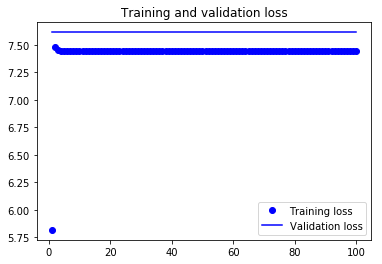

In [76]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()


In [12]:
HIDDEN_SIZE=50
BATCH_SIZE=128
EMB_DIM=100
def define_model(embedding_matrix,class_count):
    vocab_length = len(embedding_matrix)

    model = Sequential()
    model.add(Embedding(input_dim=vocab_length,
                        output_dim=EMB_DIM,
                        weights=[embedding_matrix],
                        input_length=100,
                        trainable=True))
    #model.add(Flatten())
    model.add(LSTM(HIDDEN_SIZE,dropout=0.2))
    model.add(Dense(class_count, activation='softmax'))
    
    model.compile(optimizer='adam',
                 loss="categorical_crossentropy",
                 metrics=["accuracy"])
    return model

pos_model = define_model(embedding_matrix, len(tag2id))
pos_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          27059400  
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 153       
Total params: 27,089,753
Trainable params: 27,089,753
Non-trainable params: 0
_________________________________________________________________


In [13]:
history = pos_model.fit(x_train, y_train,batch_size= BATCH_SIZE,epochs=100,verbose=1,validation_data=(x_val, y_val))

Train on 400 samples, validate on 1480 samples
Epoch 1/100
400/400 [==============================] - 5s 13ms/step - loss: 1.1465 - acc: 0.3450 - val_loss: 1.0589 - val_acc: 0.4818
Epoch 2/100
400/400 [==============================] - 3s 6ms/step - loss: 1.0537 - acc: 0.4675 - val_loss: 1.0309 - val_acc: 0.5115
Epoch 3/100
400/400 [==============================] - 3s 6ms/step - loss: 0.9857 - acc: 0.5350 - val_loss: 1.0137 - val_acc: 0.5236
Epoch 4/100
400/400 [==============================] - 3s 6ms/step - loss: 0.9704 - acc: 0.5325 - val_loss: 0.9998 - val_acc: 0.5358
Epoch 5/100
400/400 [==============================] - 3s 7ms/step - loss: 0.9439 - acc: 0.5575 - val_loss: 0.9735 - val_acc: 0.5365
Epoch 6/100
400/400 [==============================] - 3s 7ms/step - loss: 0.9181 - acc: 0.5875 - val_loss: 0.9482 - val_acc: 0.5480
Epoch 7/100
400/400 [==============================] - 3s 6ms/step - loss: 0.8890 - acc: 0.5725 - val_loss: 0.9291 - val_acc: 0.5541
Epoch 8/100
400/400 [

Epoch 62/100
400/400 [==============================] - 3s 7ms/step - loss: 0.1585 - acc: 0.9650 - val_loss: 0.7157 - val_acc: 0.7189
Epoch 63/100
400/400 [==============================] - 3s 7ms/step - loss: 0.1728 - acc: 0.9675 - val_loss: 0.7064 - val_acc: 0.7270
Epoch 64/100
400/400 [==============================] - 3s 7ms/step - loss: 0.1500 - acc: 0.9800 - val_loss: 0.7015 - val_acc: 0.7304
Epoch 65/100
400/400 [==============================] - 3s 7ms/step - loss: 0.1494 - acc: 0.9675 - val_loss: 0.7031 - val_acc: 0.7304
Epoch 66/100
400/400 [==============================] - 3s 7ms/step - loss: 0.1299 - acc: 0.9675 - val_loss: 0.7115 - val_acc: 0.7304
Epoch 67/100
400/400 [==============================] - 3s 6ms/step - loss: 0.1376 - acc: 0.9775 - val_loss: 0.7137 - val_acc: 0.7297
Epoch 68/100
400/400 [==============================] - 3s 7ms/step - loss: 0.1383 - acc: 0.9650 - val_loss: 0.7154 - val_acc: 0.7318
Epoch 69/100
400/400 [==============================] - 3s 7ms

In [14]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()


In [15]:
history = pos_model.fit(x_train, y_train,batch_size= BATCH_SIZE,epochs=50,verbose=1,validation_data=(x_val, y_val))

Train on 400 samples, validate on 1480 samples
Epoch 1/50
400/400 [==============================] - 3s 6ms/step - loss: 0.0764 - acc: 0.9900 - val_loss: 0.7737 - val_acc: 0.7473
Epoch 2/50
400/400 [==============================] - 3s 6ms/step - loss: 0.0742 - acc: 0.9900 - val_loss: 0.7718 - val_acc: 0.7459
Epoch 3/50
400/400 [==============================] - 3s 6ms/step - loss: 0.0689 - acc: 0.9850 - val_loss: 0.7692 - val_acc: 0.7473
Epoch 4/50
400/400 [==============================] - 3s 6ms/step - loss: 0.0649 - acc: 0.9900 - val_loss: 0.7722 - val_acc: 0.7446
Epoch 5/50
400/400 [==============================] - 3s 6ms/step - loss: 0.0586 - acc: 0.9925 - val_loss: 0.7659 - val_acc: 0.7446
Epoch 6/50
400/400 [==============================] - 3s 6ms/step - loss: 0.0788 - acc: 0.9750 - val_loss: 0.7637 - val_acc: 0.7473
Epoch 7/50
400/400 [==============================] - 3s 7ms/step - loss: 0.0602 - acc: 0.9875 - val_loss: 0.7678 - val_acc: 0.7446
Epoch 8/50
400/400 [=========

In [18]:
HIDDEN_SIZE=32
BATCH_SIZE=128
EMB_DIM=100
def define_model(embedding_matrix,class_count):
    vocab_length = len(embedding_matrix)

    model = Sequential()
    model.add(Embedding(input_dim=vocab_length,
                        output_dim=EMB_DIM,
                        weights=[embedding_matrix],
                        input_length=100,
                        trainable=True))
    #model.add(Flatten())
    model.add(LSTM(HIDDEN_SIZE,dropout=0.2,return_sequences=True))
    model.add(LSTM(64,dropout=0.2))
    model.add(Dense(class_count, activation='softmax'))
    
    model.compile(optimizer='adam',
                 loss="categorical_crossentropy",
                 metrics=["accuracy"])
    return model

pos_model = define_model(embedding_matrix, len(tag2id))
pos_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 100)          27059400  
_________________________________________________________________
lstm_5 (LSTM)                (None, 100, 32)           17024     
_________________________________________________________________
lstm_6 (LSTM)                (None, 64)                24832     
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 195       
Total params: 27,101,451
Trainable params: 27,101,451
Non-trainable params: 0
_________________________________________________________________


In [19]:
history = pos_model.fit(x_train, y_train,batch_size= BATCH_SIZE,epochs=50,verbose=1,validation_data=(x_val, y_val))

Train on 400 samples, validate on 1480 samples
Epoch 1/50
400/400 [==============================] - 7s 17ms/step - loss: 1.0952 - acc: 0.3575 - val_loss: 1.0202 - val_acc: 0.5311
Epoch 2/50
400/400 [==============================] - 3s 8ms/step - loss: 1.0249 - acc: 0.5325 - val_loss: 0.9851 - val_acc: 0.5297
Epoch 3/50
400/400 [==============================] - 3s 8ms/step - loss: 0.9936 - acc: 0.5200 - val_loss: 0.9865 - val_acc: 0.5297
Epoch 4/50
400/400 [==============================] - 3s 8ms/step - loss: 0.9815 - acc: 0.5250 - val_loss: 0.9721 - val_acc: 0.5311
Epoch 5/50
400/400 [==============================] - 3s 8ms/step - loss: 0.9572 - acc: 0.5400 - val_loss: 0.9537 - val_acc: 0.5358
Epoch 6/50
400/400 [==============================] - 3s 8ms/step - loss: 0.9464 - acc: 0.5400 - val_loss: 0.9426 - val_acc: 0.5399
Epoch 7/50
400/400 [==============================] - 3s 8ms/step - loss: 0.9326 - acc: 0.5625 - val_loss: 0.9367 - val_acc: 0.5426
Epoch 8/50
400/400 [========

In [20]:
history1 = pos_model.fit(x_train, y_train,batch_size= BATCH_SIZE,epochs=50,verbose=1,validation_data=(x_val, y_val))

Train on 400 samples, validate on 1480 samples
Epoch 1/50
400/400 [==============================] - 3s 8ms/step - loss: 0.1828 - acc: 0.9325 - val_loss: 0.7990 - val_acc: 0.7534
Epoch 2/50
400/400 [==============================] - 3s 8ms/step - loss: 0.1809 - acc: 0.9325 - val_loss: 0.8211 - val_acc: 0.7466
Epoch 3/50
400/400 [==============================] - 3s 8ms/step - loss: 0.1932 - acc: 0.9125 - val_loss: 0.8352 - val_acc: 0.7473
Epoch 4/50
400/400 [==============================] - 3s 8ms/step - loss: 0.1664 - acc: 0.9400 - val_loss: 0.8496 - val_acc: 0.7649
Epoch 5/50
400/400 [==============================] - 3s 8ms/step - loss: 0.1655 - acc: 0.9325 - val_loss: 0.8311 - val_acc: 0.7649
Epoch 6/50
400/400 [==============================] - 3s 8ms/step - loss: 0.1369 - acc: 0.9500 - val_loss: 0.8176 - val_acc: 0.7466
Epoch 7/50
400/400 [==============================] - 3s 8ms/step - loss: 0.1790 - acc: 0.9250 - val_loss: 0.7964 - val_acc: 0.7459
Epoch 8/50
400/400 [=========

In [21]:
history2 = pos_model.fit(x_train, y_train,batch_size= BATCH_SIZE,epochs=20,verbose=1,validation_data=(x_val, y_val))

Train on 400 samples, validate on 1480 samples
Epoch 1/20
400/400 [==============================] - 3s 8ms/step - loss: 0.0922 - acc: 0.9650 - val_loss: 0.9850 - val_acc: 0.7581
Epoch 2/20
400/400 [==============================] - 3s 8ms/step - loss: 0.0725 - acc: 0.9775 - val_loss: 0.9734 - val_acc: 0.7655
Epoch 3/20
400/400 [==============================] - 3s 8ms/step - loss: 0.0779 - acc: 0.9725 - val_loss: 0.9790 - val_acc: 0.7662
Epoch 4/20
400/400 [==============================] - 3s 8ms/step - loss: 0.0617 - acc: 0.9750 - val_loss: 0.9636 - val_acc: 0.7716
Epoch 5/20
400/400 [==============================] - 3s 8ms/step - loss: 0.0615 - acc: 0.9825 - val_loss: 1.0171 - val_acc: 0.7581
Epoch 6/20
400/400 [==============================] - 3s 8ms/step - loss: 0.0992 - acc: 0.9575 - val_loss: 0.9559 - val_acc: 0.7520
Epoch 7/20
400/400 [==============================] - 3s 8ms/step - loss: 0.0866 - acc: 0.9725 - val_loss: 0.9692 - val_acc: 0.7453
Epoch 8/20
400/400 [=========

In [23]:
HIDDEN_SIZE=32
BATCH_SIZE=128
EMB_DIM=100
def define_model(embedding_matrix,class_count):
    vocab_length = len(embedding_matrix)

    model = Sequential()
    model.add(Embedding(input_dim=vocab_length,
                        output_dim=EMB_DIM,
                        weights=[embedding_matrix],
                        input_length=100,
                        trainable=True))
    model.add(Flatten())
    model.add(Dense(32,activation="relu"))
    model.add(Dense(64,activation="relu"))
    model.add(Dense(128,activation="relu"))
    model.add(Dense(256,activation="relu"))
    model.add(Dense(256,activation="relu"))
    model.add(Dense(128,activation="relu"))
    model.add(Dense(64,activation="relu"))
    model.add(Dense(32,activation="relu"))
    model.add(Dense(16,activation="relu"))
    model.add(Dense(class_count, activation='softmax'))
    
    model.compile(optimizer='adam',
                 loss="categorical_crossentropy",
                 metrics=["accuracy"])
    return model

pos_model = define_model(embedding_matrix, len(tag2id))
pos_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 100, 100)          27059400  
_________________________________________________________________
flatten_2 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_5 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_6 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_7 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_8 (Dense)              (None, 256)               65792     
__________

In [24]:
history = pos_model.fit(x_train, y_train,batch_size= BATCH_SIZE,epochs=100,verbose=1,validation_data=(x_val, y_val))

Train on 400 samples, validate on 1480 samples
Epoch 1/100
400/400 [==============================] - 4s 11ms/step - loss: 1.0922 - acc: 0.4175 - val_loss: 1.1686 - val_acc: 0.5297
Epoch 2/100
400/400 [==============================] - 2s 4ms/step - loss: 1.1062 - acc: 0.5350 - val_loss: 1.0366 - val_acc: 0.5297
Epoch 3/100
400/400 [==============================] - 2s 4ms/step - loss: 1.0224 - acc: 0.5300 - val_loss: 1.0191 - val_acc: 0.5297
Epoch 4/100
400/400 [==============================] - 2s 5ms/step - loss: 1.0306 - acc: 0.5300 - val_loss: 1.0158 - val_acc: 0.5297
Epoch 5/100
400/400 [==============================] - 2s 5ms/step - loss: 1.0109 - acc: 0.5300 - val_loss: 1.0064 - val_acc: 0.5297
Epoch 6/100
400/400 [==============================] - 2s 5ms/step - loss: 0.9973 - acc: 0.5300 - val_loss: 1.0092 - val_acc: 0.5297
Epoch 7/100
400/400 [==============================] - 2s 5ms/step - loss: 0.9945 - acc: 0.5300 - val_loss: 1.0364 - val_acc: 0.5297
Epoch 8/100
400/400 [

Epoch 62/100
400/400 [==============================] - 2s 5ms/step - loss: 0.1596 - acc: 0.9375 - val_loss: 1.9618 - val_acc: 0.5973
Epoch 63/100
400/400 [==============================] - 2s 4ms/step - loss: 0.1609 - acc: 0.9425 - val_loss: 1.6050 - val_acc: 0.6047
Epoch 64/100
400/400 [==============================] - 2s 5ms/step - loss: 0.1249 - acc: 0.9625 - val_loss: 1.7362 - val_acc: 0.5993
Epoch 65/100
400/400 [==============================] - 2s 5ms/step - loss: 0.0949 - acc: 0.9700 - val_loss: 2.2799 - val_acc: 0.5824
Epoch 66/100
400/400 [==============================] - 2s 5ms/step - loss: 0.1241 - acc: 0.9550 - val_loss: 2.0567 - val_acc: 0.5939
Epoch 67/100
400/400 [==============================] - 2s 4ms/step - loss: 0.0777 - acc: 0.9650 - val_loss: 2.4082 - val_acc: 0.5932
Epoch 68/100
400/400 [==============================] - 2s 4ms/step - loss: 0.1988 - acc: 0.9325 - val_loss: 1.9894 - val_acc: 0.6088
Epoch 69/100
400/400 [==============================] - 2s 5ms

In [28]:
BATCH_SIZE=64
EMB_DIM=100
def define_model(embedding_matrix,class_count):
    vocab_length = len(embedding_matrix)

    model = Sequential()
    model.add(Embedding(input_dim=vocab_length,
                        output_dim=EMB_DIM,
                        weights=[embedding_matrix],
                        input_length=100,
                        trainable=True))
    #model.add(Flatten())
    model.add(SpatialDropout1D(0.2))
    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(class_count, activation='softmax'))
    
    model.compile(optimizer='adam',
                 loss="categorical_crossentropy",
                 metrics=["accuracy"])
    return model

pos_model = define_model(embedding_matrix, len(tag2id))
pos_model.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 100, 100)          27059400  
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 100, 100)          0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_15 (Dense)             (None, 3)                 303       
Total params: 27,140,103
Trainable params: 27,140,103
Non-trainable params: 0
_________________________________________________________________


In [29]:
history = pos_model.fit(x_train, y_train,batch_size= BATCH_SIZE,epochs=100,verbose=1,validation_data=(x_val, y_val))

Train on 400 samples, validate on 1480 samples
Epoch 1/100
400/400 [==============================] - 8s 20ms/step - loss: 1.0966 - acc: 0.4350 - val_loss: 1.0317 - val_acc: 0.5459
Epoch 2/100
400/400 [==============================] - 5s 13ms/step - loss: 0.9620 - acc: 0.5500 - val_loss: 0.9860 - val_acc: 0.5486
Epoch 3/100
400/400 [==============================] - 5s 13ms/step - loss: 0.9191 - acc: 0.5975 - val_loss: 0.9448 - val_acc: 0.5500
Epoch 4/100
400/400 [==============================] - 5s 13ms/step - loss: 0.8803 - acc: 0.6125 - val_loss: 0.9021 - val_acc: 0.5770
Epoch 5/100
400/400 [==============================] - 5s 12ms/step - loss: 0.8457 - acc: 0.6325 - val_loss: 0.8861 - val_acc: 0.5784
Epoch 6/100
400/400 [==============================] - 5s 12ms/step - loss: 0.8170 - acc: 0.6525 - val_loss: 0.8614 - val_acc: 0.5973
Epoch 7/100
400/400 [==============================] - 5s 12ms/step - loss: 0.8033 - acc: 0.6600 - val_loss: 0.8370 - val_acc: 0.6149
Epoch 8/100
400

400/400 [==============================] - 5s 12ms/step - loss: 0.0792 - acc: 0.9850 - val_loss: 0.8636 - val_acc: 0.7514
Epoch 62/100
400/400 [==============================] - 5s 12ms/step - loss: 0.0781 - acc: 0.9850 - val_loss: 0.8537 - val_acc: 0.7520
Epoch 63/100
400/400 [==============================] - 5s 12ms/step - loss: 0.0951 - acc: 0.9700 - val_loss: 0.8878 - val_acc: 0.7527
Epoch 64/100
400/400 [==============================] - 5s 12ms/step - loss: 0.0897 - acc: 0.9750 - val_loss: 0.8847 - val_acc: 0.7486
Epoch 65/100
400/400 [==============================] - 5s 12ms/step - loss: 0.0784 - acc: 0.9725 - val_loss: 0.8659 - val_acc: 0.7527
Epoch 66/100
400/400 [==============================] - 5s 12ms/step - loss: 0.0847 - acc: 0.9725 - val_loss: 0.8527 - val_acc: 0.7493
Epoch 67/100
400/400 [==============================] - 6s 14ms/step - loss: 0.1023 - acc: 0.9675 - val_loss: 0.8975 - val_acc: 0.7500
Epoch 68/100
400/400 [==============================] - 6s 15ms/step

# trying to do classification only with two labels

In [38]:
y_double=[]
x_double=[]
for i in range(len(y)):
    if y[i]!=0:
        y_double.append(y[i])
        x_double.append(X[i])

In [40]:
data_double=[]

x_double=np.array(x_double)
y_double=np.array(y_double)


for i in range(x_double.shape[0]):
    chiz = (x_double[i], y_double[i])
    data_double.append(chiz)

In [44]:
from keras import preprocessing
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import  to_categorical

maxlen = 100 #number of words we look at each sample 
training_samples = 400
validation_samples = 1480
max_words = 500 # number of features 


tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(x_double)

sequences = tokenizer.texts_to_sequences(x_double)
word_index = tokenizer.word_index

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(y_double)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

y_cat=to_categorical(labels,3)

x_train = data[:training_samples]
y_train = y_cat[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = y_cat[training_samples: training_samples + validation_samples]


In [45]:
BATCH_SIZE=64
EMB_DIM=100
def define_model(embedding_matrix,class_count):
    vocab_length = len(embedding_matrix)

    model = Sequential()
    model.add(Embedding(input_dim=vocab_length,
                        output_dim=EMB_DIM,
                        weights=[embedding_matrix],
                        input_length=100,
                        trainable=True))
    #model.add(Flatten())
    model.add(SpatialDropout1D(0.2))
    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(class_count, activation='sigmoid'))
    
    model.compile(optimizer='adam',
                 loss="categorical_crossentropy",
                 metrics=["accuracy"])
    return model

pos_model = define_model(embedding_matrix, len(tag2id))
pos_model.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 100, 100)          27059400  
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 100, 100)          0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_17 (Dense)             (None, 3)                 303       
Total params: 27,140,103
Trainable params: 27,140,103
Non-trainable params: 0
_________________________________________________________________


In [46]:
history = pos_model.fit(x_train, y_train,batch_size= BATCH_SIZE,epochs=30,verbose=1,validation_data=(x_val, y_val))

Train on 400 samples, validate on 488 samples
Epoch 1/30
400/400 [==============================] - 8s 19ms/step - loss: 0.9053 - acc: 0.5600 - val_loss: 0.7216 - val_acc: 0.6947
Epoch 2/30
400/400 [==============================] - 4s 10ms/step - loss: 0.7271 - acc: 0.6975 - val_loss: 0.6768 - val_acc: 0.7234
Epoch 3/30
400/400 [==============================] - 4s 10ms/step - loss: 0.6756 - acc: 0.7050 - val_loss: 0.6576 - val_acc: 0.7500
Epoch 4/30
400/400 [==============================] - 4s 10ms/step - loss: 0.6493 - acc: 0.7425 - val_loss: 0.6263 - val_acc: 0.7541
Epoch 5/30
400/400 [==============================] - 4s 10ms/step - loss: 0.6079 - acc: 0.7100 - val_loss: 0.5780 - val_acc: 0.7541
Epoch 6/30
400/400 [==============================] - 4s 10ms/step - loss: 0.5638 - acc: 0.7575 - val_loss: 0.5273 - val_acc: 0.7643
Epoch 7/30
400/400 [==============================] - 4s 10ms/step - loss: 0.5081 - acc: 0.7875 - val_loss: 0.4916 - val_acc: 0.7807
Epoch 8/30
400/400 [===

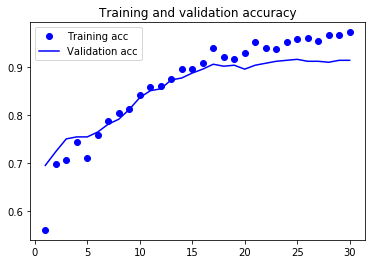

In [47]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()


In [48]:
HIDDEN_SIZE=32
BATCH_SIZE=128
EMB_DIM=100
def define_model(embedding_matrix,class_count):
    vocab_length = len(embedding_matrix)

    model = Sequential()
    model.add(Embedding(input_dim=vocab_length,
                        output_dim=EMB_DIM,
                        weights=[embedding_matrix],
                        input_length=100,
                        trainable=True))
    #model.add(Flatten())
    model.add(LSTM(HIDDEN_SIZE,dropout=0.2,return_sequences=True))
    model.add(LSTM(64,dropout=0.2))
    model.add(Dense(class_count, activation='sigmoid'))
    
    model.compile(optimizer='adam',
                 loss="binary_crossentropy",
                 metrics=["accuracy"])
    return model

pos_model = define_model(embedding_matrix, len(tag2id))
pos_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 100, 100)          27059400  
_________________________________________________________________
lstm_11 (LSTM)               (None, 100, 32)           17024     
_________________________________________________________________
lstm_12 (LSTM)               (None, 64)                24832     
_________________________________________________________________
dense_18 (Dense)             (None, 3)                 195       
Total params: 27,101,451
Trainable params: 27,101,451
Non-trainable params: 0
_________________________________________________________________


In [49]:
history = pos_model.fit(x_train, y_train,batch_size= BATCH_SIZE,epochs=50,verbose=1,validation_data=(x_val, y_val))

Train on 400 samples, validate on 488 samples
Epoch 1/50
400/400 [==============================] - 7s 18ms/step - loss: 0.6720 - acc: 0.6158 - val_loss: 0.5992 - val_acc: 0.7179
Epoch 2/50
400/400 [==============================] - 3s 6ms/step - loss: 0.6019 - acc: 0.7217 - val_loss: 0.5401 - val_acc: 0.7657
Epoch 3/50
400/400 [==============================] - 3s 7ms/step - loss: 0.5458 - acc: 0.7408 - val_loss: 0.4891 - val_acc: 0.7739
Epoch 4/50
400/400 [==============================] - 3s 6ms/step - loss: 0.4912 - acc: 0.7450 - val_loss: 0.4588 - val_acc: 0.6926
Epoch 5/50
400/400 [==============================] - 3s 6ms/step - loss: 0.4552 - acc: 0.7217 - val_loss: 0.4370 - val_acc: 0.7234
Epoch 6/50
400/400 [==============================] - 3s 6ms/step - loss: 0.4362 - acc: 0.7408 - val_loss: 0.4164 - val_acc: 0.8115
Epoch 7/50
400/400 [==============================] - 3s 6ms/step - loss: 0.4225 - acc: 0.7933 - val_loss: 0.4120 - val_acc: 0.7842
Epoch 8/50
400/400 [=========

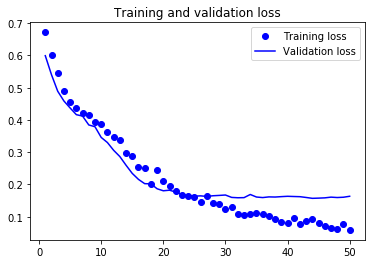

In [50]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()
